In [43]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import metrics

In [44]:
%matplotlib inline

In [45]:
data_source_path = "F:\deep lerning project\data\FinalData\d1.wordpress_phpbb23.label_appearance.csv"

#test_output_file = open("F:\\deep lerning project\\data\\FinalData\\hidden_layer_test_output.txt", mode = 'w')# for testing layers...delete if not needed
# for slicing the necessary columns from the source file...directly related to source data columns
label_col_start = 0
feature_col_start = 8

# I have many labels but here is the col that contains 'changed_ever_class'
class_label_col = 2 # class is in col 2

In [46]:
# Some configurations
# set only one to true...
select_model_based_on_loss = False
select_model_based_on_error_rate = False
select_model_based_on_auc = True
#---------------------------------

In [47]:
def get_feature_and_label():
    # read the data file
    # return features and labels
    
    file_change_df = pd.read_csv(data_source_path)
    
    X = file_change_df.iloc[:,feature_col_start:]
    #print(X.shape)
    #print(X)
    
    y_all_labels = file_change_df.iloc[:,label_col_start:feature_col_start] # all available labels 
    #print(type(y_all_labels))
    #print(y_all_labels)
    y = y_all_labels.iloc[:,class_label_col] # take the changed_ever col only
    y = pd.Series.to_frame(y) # y is a series...convert it to dataframe again--- not necessary...series will do
    #print(y.head())
    #print(type(y))
    
    #print(y.shape)
    #print(y)
    
    return X, y

In [48]:
def get_train_test_split(X, y, nsplits = 1, testSize = 0.2):

    sss = StratifiedShuffleSplit(n_splits=nsplits, test_size=testSize)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] # X.iloc[index] because its pandas dataframe.so..iloc
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    return X_train, y_train, X_test, y_test

In [49]:
def show_data_statistics(X_train, y_train, X_test, y_test):
    #print(X_train.shape)
    #print(y_train.shape)
    #print(X_test.shape)
    #print(y_test.shape)
    #print(type(y_test))
    print("y_train Statistics:\n", y_train.describe())
    print("y_test Statistics:\n",y_test.describe())
    
    plt.hist(y_train)
    plt.hist(y_test)

In [50]:
def get_feature_cols(X):
    feature_cols = []
    i=0

    for col in X.columns:
        #if is_numeric_dtype(X[col]): #is_numeric_dtype is pandas function
        feature_cols.extend([tf.feature_column.numeric_column(col)])
        i = i+1
        
    print("Total features column names converted to tf.feature_column.numeric_column('col_name') = ", i)
    return feature_cols

In [51]:
def train_model(model, X_train, y_train):
    
    input_func = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        batch_size=10,
        num_epochs=3000,
        shuffle=True)    
    
    model = model.train(input_fn=input_func,steps=3000)
    
    return model

In [52]:
def evaluate_model(model, X_test, y_test):
    
    input_func = tf.estimator.inputs.pandas_input_fn(
      x=X_test,
      y=y_test,
      batch_size=100,
      num_epochs=1,
      shuffle=False)
    
    results = model.evaluate(input_func)
    #print(results)
    
    return results
    

In [53]:
def prediction(model, X, y):
    
    prediction_list = []
    y_proba_positive_class_list = [] # positive class probability of each element for calculating AUC
    
    input_func = tf.estimator.inputs.pandas_input_fn(
      x=X,
      batch_size=100,
      num_epochs=1,
      shuffle=False)
    
    y_predicted = model.predict(input_func)
    
    for elem in y_predicted: # y_predicted is a generator object holds a memory address...read all values from there
        #print("type elem:", type(elem))
        #print("elem:", elem)
        elem_probabilities = np.array(elem['probabilities'])
        #print("Elem probabilities of each class:", elem_probabilities)
        
        y_proba_positive_class_list.append(elem_probabilities[1]) # class 1 is the positive class, its index is 1
        #print("prob_list_now:", elem_positive_class_proba_list)
        
        elem_class = np.argmax(elem_probabilities) # one probable class based on the index that contain max value
        #print("probable class:",elem_class)
        
        prediction_list.append(elem_class)
        
    
    # assign prediction list to y_predicted for consistent name
    y_predicted = np.array(prediction_list)
    
    #print("y_predicted_shape:", y_predicted.shape, "val:", y_predicted)
    #print("y_type:", type(y),"y shape:", y.shape, "val:", y)
    
    #error_rate = sum(y_predicted != np.array(y)/len(y_predicted))
    
    #print(list(y_predicted))
    
    y = np.array(y) # convert y data to np array
    r,c = y.shape
    #print("y- r,c:",r,c)
    y = y.reshape(r) # change the shape of y to numpy [row,]
    #print("y-shape:", y.shape)
    
    
    '''
    print("before converting to list y_predicted:", y_predicted)
    
    y_predicted = list(y_predicted)
    print("y_predicted:", y_predicted)
    
    y_predicted = np.array(y_predicted)
    print("after converting to nparray y_predicted:", y_predicted, "shape:", y_predicted.shape)
    
    y= np.array(y)
    r,c = y.shape
    print("y- r,c:",r,c)
    y = y.reshape(r)
    print("y-shape:", y.shape)
    '''
    
    error_rate = sum(y_predicted != y)/len(y_predicted) # sum needs the operands in np array of shape [row,]
    
    return y_predicted, error_rate, y_proba_positive_class_list

In [54]:
def get_normalized_train_data(X_train):
    #Unused function---Normalization is done separately
    #print(type(X_train))
    #print(X_train.head())
    saved_cols = X_train.columns # save the columns names..scaling change the pandas frame to numpy..need to restore
    saved_index = list(X_train.index) # # scaling changes pandas X indices..need to restore to match with y data indices
    #print("saved_index", saved_index)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    
    scaled_X_train = min_max_scaler.fit_transform(X_train)
    scaled_X_train = pd.DataFrame(scaled_X_train, index=saved_index, columns=saved_cols)# restore the column names

    #print(scaled_X_train.head())
    return scaled_X_train

In [55]:
def get_random_sample(X, y, n_sample = 1):
    n = np.arange(X.shape[0]) # generate numbers equal to the max no of rows in the X df
    if n_sample>len(n):
        print("You have asked", n_sample, " samples, but the training data has", len(n), " rows. Returning 1 sample...")
        n_sample = 1
        
    np.random.shuffle(n) # shuffle all the numbers representing row index
    index = n[0:n_sample] # take the numbers from 0 to given sample
    
    X_sample = X.iloc[index]
    y_sample = y.iloc[index]
    
    #print(X_sample.head())
    #print(y_sample.head())
    
    return X_sample, y_sample

In [56]:
def show_evaluation_error_report(eval_error_rates):
    
    eval_error_rate_avg = sum(eval_error_rates)/len(eval_error_rates)
    model_std = np.std(eval_error_rates)
    
    print("Evaluation Errors:", eval_error_rates)
    print('Evaluation error rate average:', eval_error_rate_avg, '\nModel\'s standard deviation:', model_std)

In [57]:
def calculate_performance_metrics(cnf_matrix):
    
    TP = cnf_matrix[1,1]
    TN = cnf_matrix[0,0]
    FP = cnf_matrix[0,1]
    FN = cnf_matrix[1,0]
    
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_recall = TP/(TP+FN) # Recall
    # Specificity or true negative rate
    TNR = TN/(TN+FP) # **
    # Precision or positive predictive value
    PPV_precision = TP/(TP+FP) # precision
    # Negative predictive value
    NPV = TN/(TN+FN) #**
    # Fall out or false positive rate
    FPR_false_positive = FP/(FP+TN)
    # False negative rate
    FNR_false_negative = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP) # **

    # Overall accuracy
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    f_measure = 2/((1.0/TPR_recall) + (1.0/PPV_precision)) #https://en.wikipedia.org/wiki/F1_score
    
    # ** some extra values are calculated but not returned
    return TPR_recall, PPV_precision, FPR_false_positive, FNR_false_negative, accuracy, f_measure

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [59]:
def get_roc_auc(y, y_proba_positive_class_list):
    
    y = y.as_matrix() # convert series data to numpy array
    
    auc = metrics.roc_auc_score(y, y_proba_positive_class_list)
    #print("Auc:", auc)
    
    '''
    #This one also works but not needed
    fpr, tpr, thresholds = metrics.roc_curve(y, elem_positive_class_proba_list)
    auc2 = metrics.auc(fpr, tpr)
    print("AUC2:", auc2, "fpr:", fpr, "tpr:", tpr)
    '''
    return auc

In [60]:
def get_cnf_matrix_prf_metrics(y, y_predicted):
    
    y = y.values.tolist() # convert pandas data to list
    #print(">>>>>type_y:", type(y), "val:", y)
    
    y = list(np.array(y).flat) # when converted to list panda gives [[values], [values]]...convert them to flat list[]
    #print("----------type_y_f:", type(y), "val:", y)
    
    
    y_predicted = list(y_predicted)
    #print(">>>>>>type_y_predicted:", type(y_predicted), "val:", y_predicted)
    
    cnf_matrix = confusion_matrix(y, y_predicted)
    
    #print("conf matrix:", cnf_matrix)
    # Calculate performane metrics
    TPR_recall, PPV_precision, FPR_false_positive, FNR_false_negative, accuracy, f_measure = calculate_performance_metrics(cnf_matrix)
    
    return cnf_matrix, TPR_recall, PPV_precision, FPR_false_positive, FNR_false_negative, accuracy, f_measure
    

In [61]:
def show_confusion_matrix(cnf_matrix, class_names):
    # show cmap of confusion metrics
    np.set_printoptions(precision=2) # settings for printing floating point values
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [62]:
def main():
    
    X, y = get_feature_and_label()
    X_train_0, y_train_0, X_test_final, y_test_final = get_train_test_split(X,y) #get_train_test_split(X, y, nsplits = 1, testSize = 0.2)

    #show_data_statistics("---Train-Test Statistics---",X_train, y_train, X_test, y_test)
    #print(type(X))
    feature_cols = get_feature_cols(X_train_0)
    #print(feature_cols)

    # start k-fold cross validation and find the best model with the minimum loss during evaluation
    
    min_loss = float('inf')
    min_error_rate = float("inf")
    max_auc = float("-inf")

    folding_session = 0
    eval_error_rates = []
    
    sss = StratifiedShuffleSplit(n_splits=10) #stratifiedkfold generates error for y_train_0 and doesn't work if y multi-labe
    
    for train_index, eval_index in sss.split(X_train_0, y_train_0):

        X_train, X_eval = X_train_0.iloc[train_index], X_train_0.iloc[eval_index]  # iloc[index] because X is a pandas dataframe
        y_train, y_eval = y_train_0.iloc[train_index], y_train_0.iloc[eval_index]
        

        #X_train = get_normalized_train_data(X_train) # min-max standardization
        #print(X_train.head())
        
        # Add layers in this list if more layer settings are needed
        hidden_layers_units = [
            [1022, 511, 255, 128]
        ]
        
        for my_hidden_units in hidden_layers_units:
            print("Hidden Settings:", my_hidden_units)
            #create a new estimator model

            file_change_prediction_model = tf.estimator.DNNClassifier(
                                                                    hidden_units = my_hidden_units,
                                                                    feature_columns = feature_cols, 
                                                                    n_classes=2, 
                                                                    activation_fn = tf.nn.relu)

            #print("new:", file_change_prediction_model)    

            #train the model
            file_change_prediction_model = train_model(file_change_prediction_model, X_train, y_train)
            #print("ret:", file_change_prediction_model)

            #evaluate the trained model
            evaluation_res = evaluate_model(file_change_prediction_model, X_eval, y_eval)
            print("Evaluation using Tensorflow evaluate method...Result at folding session:", folding_session, evaluation_res,"\n\n")
            
            # Do my own evaluation using the trained model in this folding session using evaluation data
            y_predicted, error_rate, y_proba_positive_class_list = prediction(file_change_prediction_model, X_eval, y_eval)
            eval_error_rates.append(error_rate) # error_rate of current folding session
            
            # calculate auc
            auc_evaluation = get_roc_auc(y_eval, y_proba_positive_class_list)

            #----
            #print("\nHidden Settings:", my_hidden_units, file=test_output_file)
            #print('\nFolding Session', folding_session,"AUC:",auc_validation,"Accuracy:", 1-error_rate, 'Error_rate:', error_rate, file=test_output_file)
            print('\n-----Folding Session', folding_session, "Hidden Settings:", my_hidden_units, "-----\nAUC:",auc_evaluation, "Accuracy:", 1-error_rate, 'Error_rate:', error_rate)
    
            #----
            #select the best model using the tensorflow evaluation result
            if select_model_based_on_loss:
                if evaluation_res['loss'] < min_loss:
                    best_model = file_change_prediction_model
                    min_loss = evaluation_res['loss']
                    print("Selecting model based on min_loss.")
    
            # select the best model based on calculated error rate
            if select_model_based_on_error_rate:
                if error_rate < min_error_rate:
                    best_model = file_change_prediction_model # save the best model
                    min_error_rate = error_rate # update the min_error_rate
                    print("Selecting model based on min_error_rate.")
                
            if select_model_based_on_auc:
                if auc_evaluation > max_auc:
                    best_model = file_change_prediction_model # save the best model
                    max_auc = auc_evaluation # update the max_auc
                    print("Selecting model based on max_auc.")

            #Take the next fold in the loop
        folding_session = folding_session + 1
        #break # remove it later for k-fold...now just one fold    
    
    #============================================
    
    print("\n-----k-fold summary:-----")
    k_fold_eval_error_rates = eval_error_rates # for naming consistency with other models
    show_evaluation_error_report(k_fold_eval_error_rates) 
    
    # see the evaluation result using the best model and some random sample from the used training data
    #X_eval, y_eval = get_random_sample(X_train_0,y_train_0, n_sample = 1000)
    #test_res = evaluate_model(best_model, X_eval, y_eval)
    #print("A random evaluation of the model:\n", test_res)
    
    # Do final test using tensorflow function
    #test_res = evaluate_model(best_model, X_test_final, y_test_final)
    #print("Final performance with the best model and test data:", test_res)
    
    #Everything finished I have got the best model and now want to get the final evaluation in my format
    #----------------------------------------------------------------------------------------------------
    #predict using the best model
    y_predicted, error_rate, y_proba_positive_class_list = prediction(best_model, X_test_final, y_test_final)
    #print("shape of x test final:", X_test_final)
    
    # calculate auc
    auc_final = get_roc_auc(y_test_final, y_proba_positive_class_list)
    print("\nFinal Test>> AUC:", auc_final, "Accuracy:", 1-error_rate, "Final Error_rate:", error_rate)
    
    cnf_matrix, TPR_recall, PPV_precision, FPR_false_positive, FNR_false_negative, accuracy, f_measure = get_cnf_matrix_prf_metrics(y_test_final, y_predicted)
    print("F-measure:", f_measure, "Accuracy:",accuracy, "Recall:", TPR_recall, "Precision:", PPV_precision, "False Positive Rate:", FPR_false_positive, "False Negative Rate:", FNR_false_negative)
    
    class_names = ['0','1'] # class names in order.. 1st index for class whose label is 0, 2nd index for class whose label is 1......
    show_confusion_matrix(cnf_matrix, class_names)

Total features column names converted to tf.feature_column.numeric_column('col_name') =  1021
Hidden Settings: [1022, 511, 255, 128]
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1, '_log_step_count_steps': 100, '_model_dir': 'C:\\Users\\ASR\\AppData\\Local\\Temp\\tmpiqrhck6e', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_steps': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\ASR\AppData\Local\Temp\tmpiqrhck6e\model.ckpt.
INFO:tensorflow:loss = 6.58068, step = 1
INFO:tensorflow:global_step/sec: 8.91616
INFO:tensorflow:loss = 3.33202, step = 101 (11.387 sec)
INFO:tensorflow:global_step/sec: 3.57777
INFO:tensorflow:loss = 4.27101, step = 201 (27.919 sec)
INFO:tensorflow:global_step/sec: 3.23657
INFO:tensorflow:loss = 5.01026, step = 301 (30.928 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 3.59117
INFO:tensorflow:loss = 2.88554, step = 2501 (27.846 sec)
INFO:tensorflow:global_step/sec: 3.22304
INFO:tensorflow:loss = 4.22447, step = 2601 (31.042 sec)
INFO:tensorflow:global_step/sec: 3.21072
INFO:tensorflow:loss = 3.65712, step = 2701 (31.146 sec)
INFO:tensorflow:global_step/sec: 3.52269
INFO:tensorflow:loss = 2.72486, step = 2801 (28.419 sec)
INFO:tensorflow:global_step/sec: 3.19686
INFO:tensorflow:loss = 1.00383, step = 2901 (31.234 sec)
INFO:tensorflow:Saving checkpoints for 3000 into C:\Users\ASR\AppData\Local\Temp\tmp3wp4o5e1\model.ckpt.
INFO:tensorflow:Loss for final step: 4.70654.
INFO:tensorflow:Starting evaluation at 2018-04-18-07:18:41
INFO:tensorflow:Restoring parameters from C:\Users\ASR\AppData\Local\Temp\tmp3wp4o5e1\model.ckpt-3000
INFO:tensorflow:Finished evaluation at 2018-04-18-07:19:13
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.884354, accuracy_baseline = 0.839286, auc = 0.889492, auc_precision_recall =

INFO:tensorflow:global_step/sec: 3.27795
INFO:tensorflow:loss = 0.663033, step = 901 (30.476 sec)
INFO:tensorflow:global_step/sec: 3.56166
INFO:tensorflow:loss = 3.76208, step = 1001 (28.092 sec)
INFO:tensorflow:global_step/sec: 3.28864
INFO:tensorflow:loss = 2.64089, step = 1101 (30.423 sec)
INFO:tensorflow:global_step/sec: 3.51998
INFO:tensorflow:loss = 3.67369, step = 1201 (28.784 sec)
INFO:tensorflow:global_step/sec: 3.53035
INFO:tensorflow:loss = 1.24292, step = 1301 (27.935 sec)
INFO:tensorflow:global_step/sec: 3.21126
INFO:tensorflow:loss = 2.15848, step = 1401 (31.094 sec)
INFO:tensorflow:global_step/sec: 3.24622
INFO:tensorflow:loss = 6.21765, step = 1501 (30.821 sec)
INFO:tensorflow:global_step/sec: 3.25007
INFO:tensorflow:loss = 0.538267, step = 1601 (30.788 sec)
INFO:tensorflow:global_step/sec: 3.25175
INFO:tensorflow:loss = 0.828769, step = 1701 (30.749 sec)
INFO:tensorflow:global_step/sec: 3.55849
INFO:tensorflow:loss = 5.04674, step = 1801 (28.086 sec)
INFO:tensorflow:gl


-----Folding Session 4 Hidden Settings: [1022, 511, 255, 128] -----
AUC: 0.871053858896 Accuracy: 0.864795918367 Error_rate: 0.135204081633
Hidden Settings: [1022, 511, 255, 128]
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': 1, '_log_step_count_steps': 100, '_model_dir': 'C:\\Users\\ASR\\AppData\\Local\\Temp\\tmpw9vta3bs', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_session_config': None, '_save_checkpoints_steps': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\ASR\AppData\Local\Temp\tmpw9vta3bs\model.ckpt.
INFO:tensorflow:loss = 6.78178, step = 1
INFO:tensorflow:global_step/sec: 8.91384
INFO:tensorflow:loss = 2.9897, step = 101 (11.375 sec)
INFO:tensorflow:global_step/sec: 3.22927
INFO:tensorflow:loss = 2.93889, step = 201 (30.982 sec)
INFO:tensorflow:global_step/sec: 3.57154
INFO:tensorflow:loss = 4.9

INFO:tensorflow:global_step/sec: 3.56009
INFO:tensorflow:loss = 5.12856, step = 2501 (28.089 sec)
INFO:tensorflow:global_step/sec: 3.26078
INFO:tensorflow:loss = 1.52301, step = 2601 (31.027 sec)
INFO:tensorflow:global_step/sec: 3.18413
INFO:tensorflow:loss = 2.3012, step = 2701 (31.015 sec)
INFO:tensorflow:global_step/sec: 3.24196
INFO:tensorflow:loss = 1.14221, step = 2801 (30.877 sec)
INFO:tensorflow:global_step/sec: 3.22908
INFO:tensorflow:loss = 1.43049, step = 2901 (30.986 sec)
INFO:tensorflow:Saving checkpoints for 3000 into C:\Users\ASR\AppData\Local\Temp\tmp0_8t8zd9\model.ckpt.
INFO:tensorflow:Loss for final step: 4.81174.
INFO:tensorflow:Starting evaluation at 2018-04-18-09:23:19
INFO:tensorflow:Restoring parameters from C:\Users\ASR\AppData\Local\Temp\tmp0_8t8zd9\model.ckpt-3000
INFO:tensorflow:Finished evaluation at 2018-04-18-09:23:51
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.878401, accuracy_baseline = 0.839286, auc = 0.877371, auc_precision_recall = 

INFO:tensorflow:global_step/sec: 3.56522
INFO:tensorflow:loss = 1.41186, step = 901 (28.033 sec)
INFO:tensorflow:global_step/sec: 3.26273
INFO:tensorflow:loss = 2.55533, step = 1001 (30.681 sec)
INFO:tensorflow:global_step/sec: 3.24388
INFO:tensorflow:loss = 4.81336, step = 1101 (30.858 sec)
INFO:tensorflow:global_step/sec: 3.58487
INFO:tensorflow:loss = 3.8767, step = 1201 (27.879 sec)
INFO:tensorflow:global_step/sec: 3.25232
INFO:tensorflow:loss = 5.75082, step = 1301 (30.747 sec)
INFO:tensorflow:global_step/sec: 3.25288
INFO:tensorflow:loss = 2.81589, step = 1401 (30.752 sec)
INFO:tensorflow:global_step/sec: 3.54236
INFO:tensorflow:loss = 0.93038, step = 1501 (28.204 sec)
INFO:tensorflow:global_step/sec: 3.59588
INFO:tensorflow:loss = 6.99568, step = 1601 (27.905 sec)
INFO:tensorflow:global_step/sec: 3.26358
INFO:tensorflow:loss = 1.4401, step = 1701 (30.546 sec)
INFO:tensorflow:global_step/sec: 3.22069
INFO:tensorflow:loss = 1.72879, step = 1801 (31.080 sec)
INFO:tensorflow:global_


-----Folding Session 9 Hidden Settings: [1022, 511, 255, 128] -----
AUC: 0.903558428888 Accuracy: 0.886054421769 Error_rate: 0.113945578231

-----k-fold summary:-----
Evaluation Errors: [0.11649659863945579, 0.11564625850340136, 0.1130952380952381, 0.125, 0.13520408163265307, 0.12159863945578231, 0.12159863945578231, 0.1130952380952381, 0.10969387755102041, 0.11394557823129252]
Evaluation error rate average: 0.118537414966 
Model's standard deviation: 0.00713678070012
INFO:tensorflow:Restoring parameters from C:\Users\ASR\AppData\Local\Temp\tmpiqrhck6e\model.ckpt-3000

Final Test>> AUC: 0.884607724638 Accuracy: 0.879591836735 Final Error_rate: 0.120408163265
F-measure: 0.930751173709 Accuracy: 0.879591836735 Recall: 0.963938411669 Precision: 0.899773071104 False Positive Rate: 0.561440677966 False Negative Rate: 0.0360615883306
Confusion matrix, without normalization
[[ 207  265]
 [  89 2379]]
Normalized confusion matrix
[[ 0.44  0.56]
 [ 0.04  0.96]]


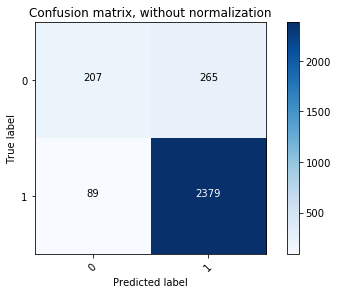

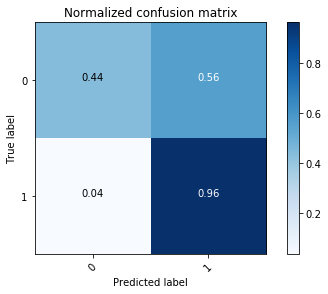

In [63]:
main()